In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
from shapely.geometry import Polygon, mapping
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.windows import Window
import earthpy as et
import earthpy.plot as ep
import cv2
import pandas as pd
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pickle

# Masking Trees from Aerial Images

## Overview:

Using remote sensing technologies, e.g., aerial and drone photography, LiDAR, satellite imaging, allow rapid gathering of large scale geospatial data. There are many challenges facing effective usage of this data, and segmenting these images into objects of interest efficiently, accurately, and programmatically is a common challenge. Image segmentation with machine learning is a rapidly growing field and helps to overcome some of these challenges. Here, I present a machine learning approach to segment trees from aerial images using a Random Forest algorithm that achieves over 95% accuracy on the training data.

---
## Approach:

### Data Acquisition

Data were provided in an AWS S3 bucket. They consist of 3, high-resolution, Geotiff format images: 1 RGB image and 2 LiDAR images. 

In [2]:
#Replace the relative path of your version of the files here
dtm_train_path = "../../data/raw_data/data/dtm_train.tif"
dsm_train_path = "../../data/raw_data/data/dsm_train.tif"
ortho_train_path = "../../data/raw_data/data/ortho_train.tif"
ortho_eval_path = "../../data/raw_data/eval_data/ortho_eval.tif"

In [3]:
#Read in RGB image
with rio.open(ortho_train_path) as ortho:
    ortho_data = ortho.read(masked = True)
#Read in LiDAR data and resample to same resolution as RGB image
with rio.open(dtm_train_path) as dtm:
    dtm_data = dtm.read(1, masked = True, out_shape = (7068, 5160), resampling = Resampling.bilinear)
with rio.open(dsm_train_path) as dsm:
    dsm_data = dsm.read(1, masked = True, out_shape = (7068, 5160), resampling = Resampling.bilinear)

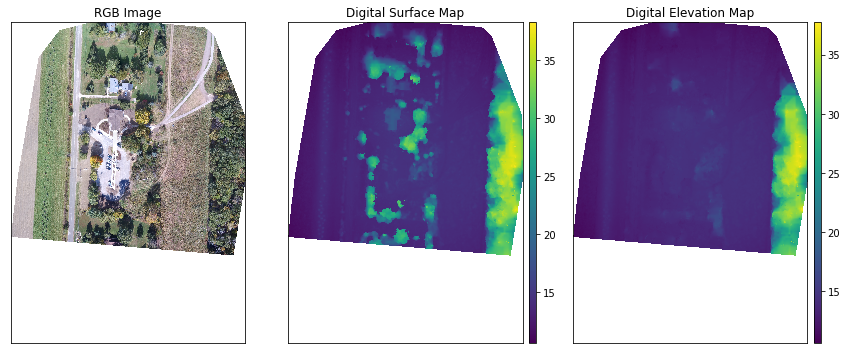

In [4]:
#Plot three provided datasets
fig, ax = plt.subplots(1, 3, figsize = (12, 5))
ep.plot_rgb(ortho_data, ax = ax[0], title = "RGB Image")
ep.plot_bands(dsm_data, ax = ax[1], title = "Digital Surface Map", cmap = 'viridis', scale = False)
ep.plot_bands(dtm_data, ax = ax[2], title = "Digital Elevation Map", cmap = 'viridis', scale = False)
plt.tight_layout();

### Creating Training Data

To train the machine learning algorithm, I first created training data by isolating trees in the training aerial image. I explored two methods of tree isolation:
1. Height-based thresholding
2. Color-based thresholding

For the height, I created a canopy height model (CHM) which represents the height of objects in the images using the LiDAR data. Pixels in the resulting CHM with a value of greater than 5 correspond well with trees in the RGB image, while excluding man-made objects such as buildings.

In [5]:
#Calculate CHM from DSM and DTM
chm = dsm_data - dtm_data

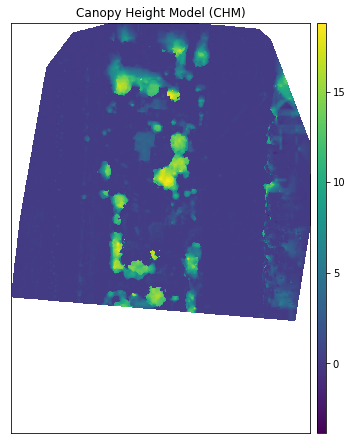

In [6]:
fig, ax = plt.subplots(figsize = (5, 8))
ep.plot_bands(chm, 
              cmap='viridis',
              title="Canopy Height Model (CHM)",
              ax = ax,
              scale=False)
plt.tight_layout();

For the color, I used the green chromatic coordinate (GCC), a measure of overall "greenness." Ideally, trees would be differentiable from buildings, bare ground, etc., and even other photosynthetic organisms (e.g., grassy fields) based on GCC, but the lighting conditions and/or phenology of trees in this image resulted in highly variable GCC values that overlapped with other non-target objects. I chose not to use GCC to isolate trees for this reason, but it may be worth revisiting in the future.

In [7]:
#Calculate GCC from RGB data (green/(red + green + blue))
gcc = ortho_data[1]/(ortho_data.sum(0))

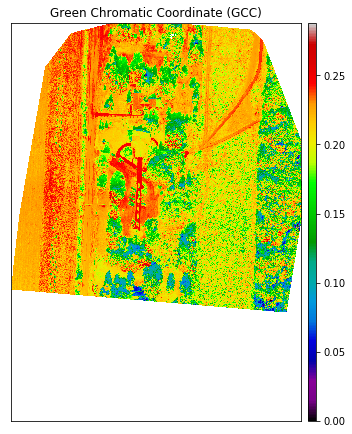

In [8]:
fig, ax = plt.subplots(figsize = (5, 8))
ep.plot_bands(gcc, 
              cmap='nipy_spectral',
              title="Green Chromatic Coordinate (GCC)",
              scale=False,
              ax = ax)
plt.tight_layout();

In [27]:
#Create tree mask by setting pixel values to 255 (tree) if CHM >= 5, 0 (background) otherwise
it = np.nditer(chm, flags = ['multi_index'])
tree_mask = chm.copy()
with it:
    while not it.finished:
        if it[0] >= 5:  
            tree_mask[it.multi_index] = 255
        else:
            tree_mask[it.multi_index] = 0
        it.iternext()
tree_mask.mask = chm.mask

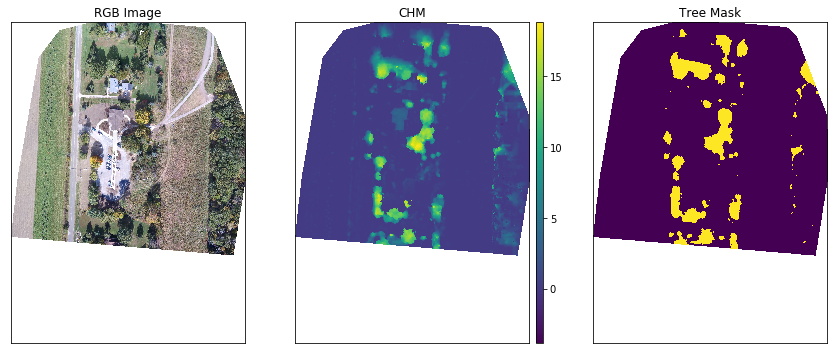

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (12, 5))
ep.plot_rgb(ortho_data, ax = ax[0], title = "RGB Image")
ep.plot_bands(chm, ax = ax[1], title = "CHM", cmap = 'viridis', scale = False)
ep.plot_bands(tree_mask, ax = ax[2], title = "Tree Mask", cmap = 'viridis', scale = False, cbar = False)
plt.tight_layout()

### Feature Extraction and Modeling
Although LiDAR data were provided for the training data, the goal is to have an algorithm that can isolate trees from aerial RBG images alone. With the tree mask created above, the next step is to create features from the image that may enable the ML algorithm to learn isolate trees without the LiDAR data. I chose a suite of edge detection and image filters to use as features in the ML algorithm. This resulted in a feature matrix with over 30 million data points for over 120 features (36470880, 126). Due to memory constraints on my local machine, I used only a tenth of this data for training the model, but I would retrain using cloud services if given more time. 

As a first pass for this image segmentation problem, I chose to use a Random Forest, which are generally fast to train and implement, while being fairly resilient to overfitting. 

_The following code is very slow to run, so I also provide a pickle (.pkl) file of the resulting pandas DataFrame._ 

In [ ]:
#Read image
img = cv2.imread(ortho_train_path)

#Isolate each color channel
imgB = img[:, :, 0]
imgG = img[:, :, 1]
imgR = img[:, :, 2]

#Reshape each channel into as a vector
imgB1 = imgB.reshape(-1)
imgG1 = imgG.reshape(-1)
imgR1 = imgR.reshape(-1)

#Instantiate an empty DataFrame for adding training data
df = pd.DataFrame()

#Add each channel to the DataFrame as a feature column
df['original_imgB'] = imgB1
df['original_imgG'] = imgG1
df['original_imgR'] = imgR1

In [ ]:
def Gabor_features(df, img, label):
    """This function creates Gabor features for provided img that will be added to the DataFrame, df. Provide a string
    for label to add a descriptive element to the feature label in the resulting DataFrame."""
    num = 1  #To count numbers up in order to give Gabor features a label in the data frame
    kernels = []  #Create empty list to hold all kernels that we will generate in a loop
    for theta in range(2):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi 
        theta = theta / 4. * np.pi
        for sigma in (1, 3):  #Sigma with values of 1 and 3
            for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
                for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
                    gabor_label = f'Gabor_{label}' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                    print(gabor_label)
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    #Now filter the image and add values to a new column 
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                    print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                    num += 1  #Increment for gabor column label
    return df

In [ ]:
def extract_features(df, img, label):
    """This function creates additional image features for provided img that will be added to the DataFrame, df. 
    Provide a string for label to add a descriptive element to the feature label in the resulting DataFrame."""
    #Canny Edge
    print(f"Calculating Canny Edge for {label}")
    edges = cv2.Canny(img, 100,200)   #Image, min and max values
    edges1 = edges.reshape(-1)
    df[f'Canny Edge_{label}'] = edges1 #Add column to original dataframe
    
    #ROBERTS EDGE
    print(f"Calculating Robert's Edge for {label}")
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df[f'Roberts_{label}'] = edge_roberts1

    #SOBEL
    print(f"Calculating Sobel Edge for {label}")
    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df[f'Sobel_{label}'] = edge_sobel1

    #SCHARR
    print(f"Calculating Scharr Edge for {label}")
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df[f'Scharr_{label}'] = edge_scharr1

    #PREWITT
    print(f"Calculating Prewitt Edge for {label}")
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df[f'Prewitt_{label}'] = edge_prewitt1

    #GAUSSIAN with sigma=3
    print(f"Calculating Gaussian Filter (sigma 3) for {label}")
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df[f'Gaussian_s3_{label}'] = gaussian_img1

    #GAUSSIAN with sigma=7
    print(f"Calculating Gaussian Filter (sigma 7) for {label}")
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df[f'Gaussian_s7_{label}'] = gaussian_img3

    #MEDIAN with sigma=3
    print(f"Calculating Median Filter (sigma 3) for {label}")
    median_img = nd.median_filter(img, size=3)
    median_img1 = median_img.reshape(-1)
    df[f'Median_s3_{label}'] = median_img1

    #VARIANCE with size=3
    print(f"Calculating Variance Filter (size 3) for {label}")
    variance_img = nd.generic_filter(img, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    df[f'Variance_s3_{label}'] = variance_img1  #Add column to original dataframe
    
    return df

In [ ]:
#Loop through each of the color channels and add features to DataFrame
for ind, val in enumerate([imgB1, imgG1, imgR1]):
    labels = ['B', 'G' , 'R']
    df = Gabor_features(df, val, labels[ind])

for ind, val in enumerate([imgB, imgG, imgR]):
    labels = ['B', 'G' , 'R']
    df = extract_features(df, val, labels[ind])

In [ ]:
#Add tree_mask labels to DataFrame
labels = tree_mask.reshape(-1)
df['Labels'] = labels

In [13]:
#OPTIONAL: Load from pickle file
with open("../../data/processed_data/training_dataframe.pkl", 'rb') as inbound: #filepath should point to pickle file location
    df = pickle.load(inbound)

In [14]:
#Due to memory constraints, I only trained on about 10% of the data. Here I randomly drop 90%.
np.random.seed(7)

remove_n = round(df.shape[0]*0.9)
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)

In [15]:
#Train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(df_subset.drop(labels = ['Labels'], axis=1), 
                                                    df_subset[['Labels']], 
                                                    random_state = 7)

In [ ]:
#Instantiate Random Forest Model and fit model
RFM = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 7)
RFM.fit(X_train, y_train)

In [17]:
#OPTIONAL: Load fit model object from pickle file
with open("../../data/models/RFM.pkl", 'rb') as model: #filepath should point to pickle file location
    RFM = pickle.load(model)

## Results:

### Model Performance on Training Data
Using a Random Forest resulted in high accuracy, over 95% on the training data. However, the data also exhibits a class imbalance, with about 95% of the training data in the background class (non-tree), so accuracy is not the best measure of model performance in this case. Recall, or the proportion of positive cases that were correctly identified, is a more appropriate measure here. The Random Forest model achieved a recall score of 0.18 on the training data. I suggest adding more training data and correcting for the class imbalance to improve this score in the future.

In [18]:
#Predict with test data and compute confusion matrix and accuracy 
test_preds = RFM.predict(X_test)
conf_matrix = conf_matrix = confusion_matrix(y_test, test_preds)
accuracy_score(y_test, test_preds)

0.9548867480027902

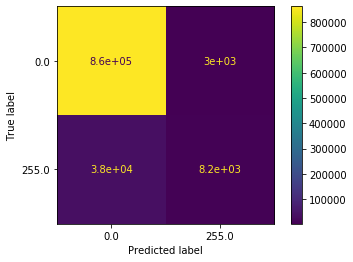

In [19]:
#Plot Confusion Matrix
plot_confusion_matrix(RFM, X_test, y_test);

In [20]:
#Calculate precision, recall, and F1 Score
precision = conf_matrix[1, 1]/ (conf_matrix[0,1] + conf_matrix[1,1]) #TP/(TP + FP)
recall = conf_matrix[1, 1]/ (conf_matrix[1,0] + conf_matrix[1,1]) #TP/(TP + FN)
f1 = 2*((precision*recall)/(precision + recall))
print(f"Precision: {round(precision, 2)}")
print(f"Recall: {round(recall, 2)}")
print(f"F1 Score: {round(f1, 2)}")

Precision: 0.73
Recall: 0.18
F1 Score: 0.29


### Evaluation on Unseen Data
Below is the result of using the Random Forest to segment trees from the evaluation image. While the model consistently identifies a few pixels in each tree, it does not satisfactorily mask the entire tree. Suggestions for improvement are given in the 'Future Directions' section below.

In [ ]:
##Process evaluation data same as training data
#Read Evaluation Data
eval_data = cv2.imread(ortho_eval_path)

#Separate color channels
evalB = eval_data[:, :, 0]
evalG = eval_data[:, :, 1]
evalR = eval_data[:, :, 2]

#Reshape color channels
evalB1 = evalB.reshape(-1)
evalG1 = evalG.reshape(-1)
evalR1 = evalR.reshape(-1)

#Instantiate empty dataframe
df_eval = pd.DataFrame()

#Add color channels to dataframe
df_eval['original_B'] = evalB1
df_eval['original_G'] = evalG1
df_eval['original_R'] = evalR1

#Add Gabor features
for ind, val in enumerate([evalB1, evalG1, evalR1]):
    labels = ['B', 'G' , 'R']
    df_eval = Gabor_features(df_eval, val, labels[ind])

#Add other features
for ind, val in enumerate([evalB, evalG, evalR]):
    labels = ['B', 'G' , 'R']
    df_eval = extract_features(df_eval, val, labels[ind])

In [21]:
#OPTIONAL: open preprocessed evaluation dataframe from pickle file
with open("../../data/processed_data/eval_dataframe.pkl", 'rb') as inbound: 
    df_eval = pickle.load(inbound)

In [22]:
#DataFrame was too large to predict all at once, so predict in chunks
first_row = 0
last_row = int(first_row + len(df_eval)/1000)
eval_preds = np.array([])
while (last_row <= len(df_eval)) and (first_row != last_row):
    df_chunk = df_eval.iloc[first_row:last_row, :]
    preds_chunk = RFM.predict(df_chunk)
    eval_preds = np.concatenate((eval_preds, preds_chunk), axis = 0)
    first_row = last_row
    if len(df_eval) - last_row < len(df_eval)/1000:
        df_chunk = df_eval.iloc[first_row:, :]
        preds_chunk = RFM.predict(df_chunk)
        eval_preds = np.concatenate((eval_preds, preds_chunk), axis = 0)
        break
    else:
        last_row = int(first_row + len(df_eval)/1000)

In [28]:
#Reshape predictions into appropriate mask shape
eval_mask = eval_preds.reshape((tree_mask.shape))
#Convert to masked array
eval_mask = np.ma.array(eval_mask)
#Add appropriate mask shape
with rio.open(ortho_eval_path, 'r') as src:
    ortho_eval = src.read(masked=True)
eval_mask.mask = ortho_eval.mask

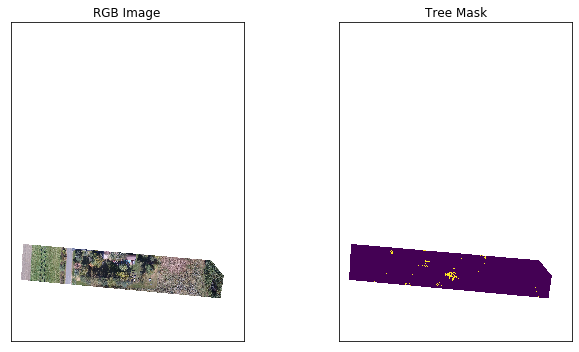

In [31]:
#Plot original evaluation RGB image and predicted tree mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ep.plot_rgb(ortho_eval, ax = ax[0], title = "RGB Image")
ep.plot_bands(eval_mask, ax = ax[1], cmap = 'viridis', scale = False, cbar = False, title="Tree Mask")
plt.tight_layout();

## Future Directions:

Given more time, I would like to improve upon this effort in the following ways:

1. Explore better methods for creating the training data. Hand-selection of trees or a more precise implementation of the methods I used here may improve the training data.
2. Retrain the Random Forest model with full dataset. Since I only used ~1/10th of the data for training due to memory constraints on my local machine, the model may be significanly improved by using the entire training dataset. I suggest moving to a cloud service for both training and prediction using this model.
3. Address class imbalance, either by upsampling the "tree class" or by creating more "tree data" from additional data sources.
4. Train and evaluate additional models. While Random Forests are quick to implement, other ML methods may provide better results. Examples include SVMs, boosted decision-tree ensembles, or deep learning methods such as convolutional neural networks. 